CIFAR-10, он состоит из картинок 32 на 32, это RGB-картинки, всего картинок у них 60 тысяч -- 50 тысяч в трейне и 10 тысяч в валидации

![alt text](https://i.gyazo.com/0789ea9fc2f201d335f83f9120fb49a2.png)



In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [4]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [5]:
len(y_train), len(y_test)

(50000, 10000)

In [6]:
# Если мы посмотрим на максимальное и минимальное значения в картинках, то окажется, 
# что минимальное значение -- "0", а максимальное -- "255". 
# Действительно, у них каждый пиксель кодируется значениями от 0 до 255 для каждого канала.
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [7]:
# Для удобства, мы отнормируем эти данные -- разделим каждый пиксель, каждое его значение, 
# на 255 и получим, что в наших картинках будут лежать значения от нуля до единицы.

X_train /= 255.
X_test /= 255.

In [8]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

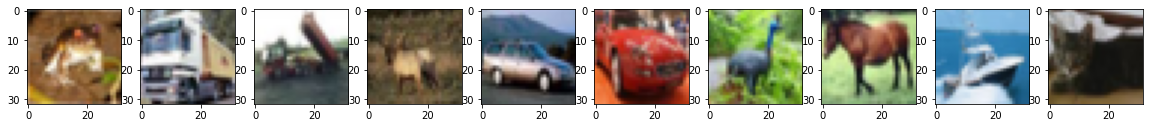

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [10]:
# Ещё одна особенность этого датасета: как и у обычных картинок, канал "цвет" кодируется в последней размерности. 
# То есть, сначала идёт высота картинки, ширина, а после этого уже цвет. 
# Но pytorch требует, чтобы этот канал шёл на первом месте.

# То есть, мы имеем сейчас 4-мерный тензор: "количество картинок, высота, ширина, количество цветов" 
#                          а Pytorch хочет: "количество картинок, количество цветов, ширина, высота"
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [11]:
# И теперь нам нужно реорганизовать размерность нашего тензора таким образом, 
# чтобы цвет шёл на втором месте -- как раз после количества картинок в датасете. 
# Это делается с помощью метода "permute".
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [12]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [13]:
# Данная нейронная сеть почти ничем не отличается от продыдущей, за исключением 
# 2 моментов: сейчас NN принимает 32x32 и в ней реализована batchNorm 

# Далее -- мы изменим нашу сеть LeNet таким образом, чтобы она принимала изображения 
# 32 на 32 и три канала на входе. Чтобы передать ей три канала, 
# нужно в in_chanels первой же конволюции поставить "3" (раньше у нас тут было "1"). 
# А вот размерность 32 на 32 у нас получается из паддинга.

class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [14]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    del net
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)

tensor(0.3876)
tensor(0.4334)
tensor(0.4709)
tensor(0.4962)
tensor(0.4969)
tensor(0.5182)
tensor(0.5263)
tensor(0.5363)
tensor(0.5425)
tensor(0.5401)
tensor(0.5462)
tensor(0.5455)
tensor(0.5432)
tensor(0.5541)
tensor(0.5564)
tensor(0.5588)
tensor(0.5550)
tensor(0.5537)
tensor(0.5534)
tensor(0.5523)
tensor(0.5545)
tensor(0.5500)
tensor(0.5449)
tensor(0.5490)
tensor(0.5472)
tensor(0.5472)
tensor(0.5427)
tensor(0.5429)
tensor(0.5394)
tensor(0.5422)
tensor(0.4327)
tensor(0.4791)
tensor(0.4900)
tensor(0.5171)
tensor(0.5307)
tensor(0.5398)
tensor(0.5594)
tensor(0.5646)
tensor(0.5807)
tensor(0.5831)
tensor(0.5940)
tensor(0.5835)
tensor(0.5992)
tensor(0.6099)
tensor(0.6010)
tensor(0.5971)
tensor(0.6089)
tensor(0.6101)
tensor(0.6085)
tensor(0.6137)
tensor(0.6161)
tensor(0.6081)
tensor(0.6244)
tensor(0.6213)
tensor(0.6227)
tensor(0.6208)
tensor(0.6180)
tensor(0.6227)
tensor(0.6204)
tensor(0.6292)
tensor(0.3759)
tensor(0.4532)
tensor(0.4933)
tensor(0.5161)
tensor(0.5259)
tensor(0.5477)
tensor(0.5

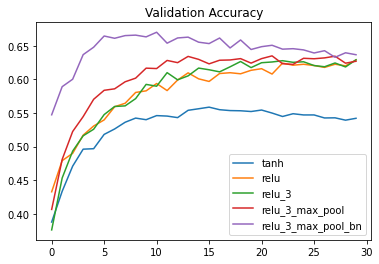

In [15]:
"""
max pooling, по сравнению с average pooling, 
на данной задаче получает очень большой boost в качестве. 
И, в принципе, на любой задаче связанной с изображениями у вас будет так же.

И, кроме того, мы видим интересную особенность батч-нормализации: 
сетка с батч-нормализацией учится очень быстро. Тот эффект, 
который мы и хотели от батч-нормализации -- ускорение обучения. 
Мы видим, что уже на пятой эпохе сетка достигает качества, 
которое без батч-нормализации достигается на 20-й эпохе. 
То есть, у нас получается ускорение в четыре раза. 
Но, кроме того, мы видим также, что батч-нормализация и переобучается быстрее. 
Логично предположить, что если весь процесс обучения ускоряется, то и момент переобучения наступает быстрее.

"""

for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

# New Section

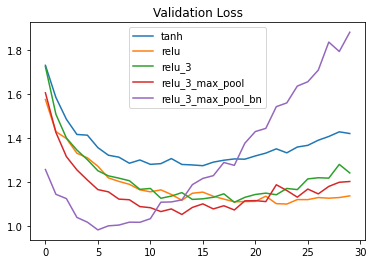

In [16]:
"""
Более явно это можно увидеть на графиках лосс-функции, в которых очевидно, 
что переобучение при батч-нормализации наступает уже на пятой эпохе и качество начинает ухудшаться. 
Очень интересный вопрос: почему качество ухудшается так сильно -- 
на графиках сетка всё ещё лучше предсказывает, чем, например стандартный LeNet с тангенсом. 
Ведь тут мы по валидации очень сильно перепрыгнули тангенс, то есть мы предсказывали гораздо хуже. 

Дело в том, что переобученные сетки -- они очень уверены в своих ответах. То есть, если мы берём сеть,
не переобученную, и она предсказывает неправильно с вероятностью 0.6, 
то переобученная сетка будет предсказывать неправильно с вероятностью "1", и, соответственно, 
её кросс-энтропия будет огромной. Здесь мы видим то же самое. 

На этом графике можно увидеть ещё одну контринтуитивную вещь. 
Если посмотреть на красную и зеленую кривые, то видно, что красная кривая переобучается, 
а зелёная ещё недообучена. Но красная кривая отвечает за две свёртки 3 на 3, а зелёная -- 
за одну свёртку 5 на 5, то есть мы хотели двумя свёртками 3 на 3 уменьшить количество весов и 
уменьшить возможность сетки для переобучения, а сделали наоборот. 

И из этого можно сделать вывод, 
что все рекомендации являются некоторыми эмпирическими фактами, 
которые могут не воспроизводиться на конкретно вашей задаче, на вашем датасете.

"""

for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

In [17]:
"""
Несмотря на то, что получилось неплохо улучшить результат LeNet на датасете CIFAR --
мы улучшили результат на целых 10%, реализация LeNet имела очень большой недостаток. 
Она хорошо справлялась с цифрами в одноканальном изображении -- цифры были очень простые. 
А вот на датасете с тремя каналами и с довольно сложными картинками она уже справлялась плохо. 
Это происходило из-за того, что фильтров в наших свёртках было очень мало.
"""

class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        # cперва мы применим батч-нормализацию к исходному изображению -- в принципе, 
        # такую батч-нормализацию можно трактовать как нормировку по яркости и контрасту изначального изображения. 
        self.batch_norm0 = torch.nn.BatchNorm2d(3) 

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        
        return x

In [18]:
accuracies['cifar_net'], losses['cifar_net'] = \
    train(CIFARNet(), X_train, y_train, X_test, y_test)

tensor(0.6685)
tensor(0.6942)
tensor(0.7184)
tensor(0.7249)
tensor(0.7276)
tensor(0.7316)
tensor(0.7243)
tensor(0.7132)
tensor(0.7206)
tensor(0.7262)
tensor(0.7245)
tensor(0.7228)
tensor(0.7128)
tensor(0.7187)
tensor(0.7131)
tensor(0.7252)
tensor(0.7239)
tensor(0.7252)
tensor(0.7248)
tensor(0.7183)
tensor(0.7235)
tensor(0.7226)
tensor(0.7202)
tensor(0.7244)
tensor(0.7193)
tensor(0.7207)
tensor(0.7248)
tensor(0.7256)
tensor(0.7204)
tensor(0.7205)


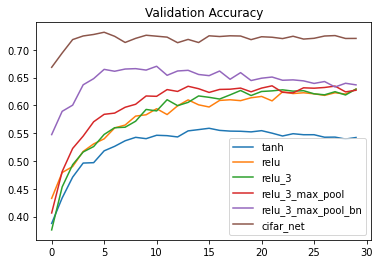

In [19]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

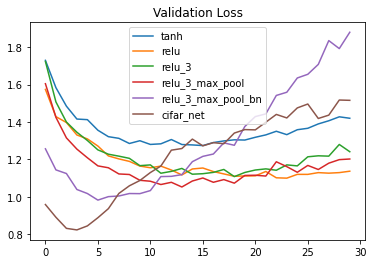

In [20]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');